<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning</font></b></strong>

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade em nosso portal: www.datascienceacademy.com.br/social

Na aula anterior criamos nosso primeiro modelo de Deep Learning para a Previsão da Média Mensal de Vendas. Agora vamos trabalhar na otimização do modelo e começaremos com um modelo Stacked LSTM. 

**Deep Learning - O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning**

Deep Learning é uma tentativa de reproduzir nas máquinas a capacidade de inteligência humana. Logo, se aumentarmos o número de camadas do modelo e aumentarmos o número de neurônios matemáticos, nosso modelo de Deep Learning fica mais "inteligente", ou seja, mais preciso. Certo? Não necessariamente!

Sei que você não quer ouvir isso, mas a verdade precisa ser dita: Tudo depende do seu problema e do seu conjunto de dados!

Para alguns problemas, a simples adição de camadas e/ou neurônios promove um aumento significativo na precisão do modelo. Para outros casos (como o nosso), pode ser um desastre. Por isso, não use o aumento de camadas/neurônios como a sua única estratégia para tentar melhorar a performance de um modelo de Deep Learning.

Vejamos o que acontece quando criamos uma rede realmente profunda!

Esta aula considera algu conhecimento em Deep Learning e esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [2]:
# Imports para modelagem preditiva - Tensorflow 1.
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [ ]:
# Imports para modelagem preditiva - Tensorflow 2.0
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import Sequential, optimizers
#from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
#from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

pandas          1.1.5
statsmodels.api 0.12.1
numpy           1.19.5
keras           2.3.1
matplotlib      3.3.3
seaborn         0.11.1
sklearn         0.24.0
statsmodels     0.12.1
Data Science Academy


## Definição do Problema de Negócio

Previsão do distanciamento social em Minas Gerais.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o distanciamento social em Minas Gerais. Os dados tem registros de 15/02/2020 a 29/01/2021.

Será fornecido 1 dataset com 2 colunas, data e distanciamento social.

In [4]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [5]:
# Dados
dataframe.head()

,QT_INTER
Data,
2020-02-15,31.6
2020-02-16,38.9
2020-02-17,24.0
2020-02-18,26.5
2020-02-19,27.8


In [6]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['QT_INTER']

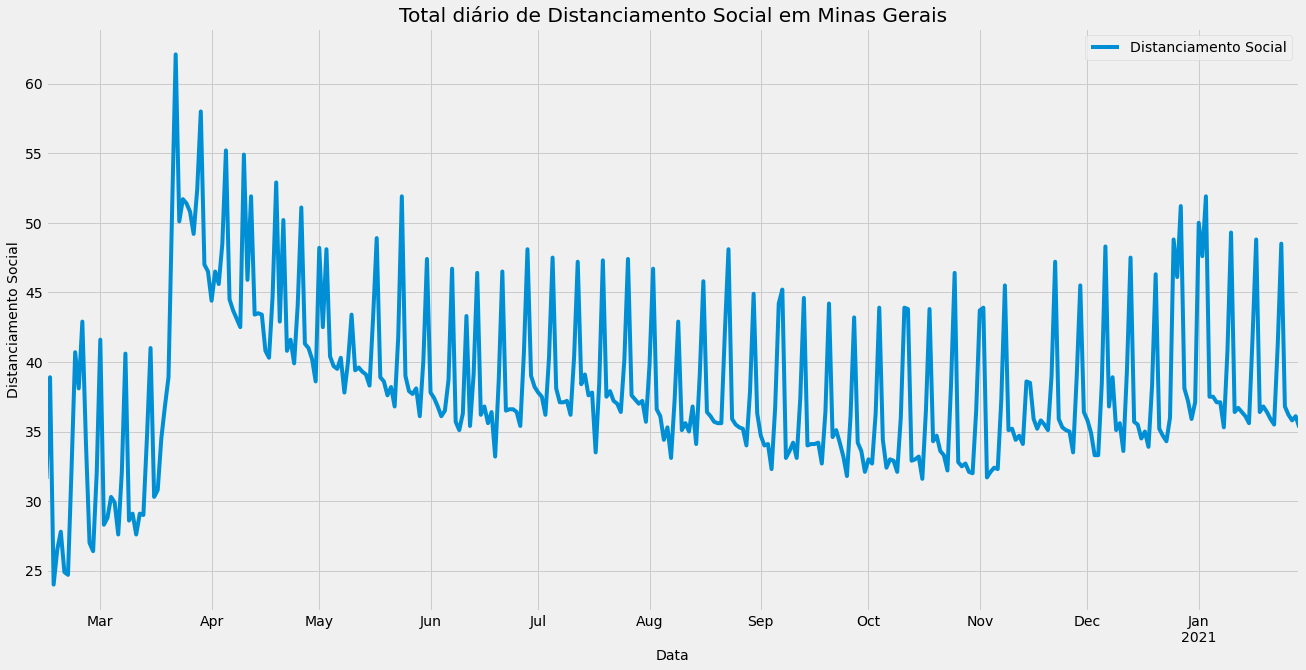

In [7]:
# Plot
target.plot(title = 'Total diário de Distanciamento Social em Minas Gerais', fontsize = 14, label = 'Distanciamento Social') 
plt.xlabel("Data") 
plt.ylabel("Distanciamento Social") 
plt.legend(loc = 'best') 
plt.show()

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

262 88


In [9]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.values.reshape(-1,1)
testset = teste.values.reshape(-1,1)

### Função Para o Cálculo da Acurácia

In [10]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## O Mito do Aumento do Número de Camadas e Neurônios em Deep Learning

Nesta aula tentaremos aumentar a precisão do nosso modelo aumentando de forma significativa o número de camadas e neurônios.

Execute o modelo e tire suas conclusões.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados.

In [11]:
# Transforma a série temporal em um problema de aprendizagem supervisionada
def timeseries_to_supervised(data, lag = 1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = pd.concat(columns, axis = 1)
    df.fillna(0, inplace = True)
    return df

In [12]:
# Cria uma série diferenciada para tornar a série temporal estacionária
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [13]:
# Inverte valor diferenciado
def inverse_difference(history, yhat, interval = 1):
    return yhat + history[-interval]

In [14]:
# Transforma a série temporal em estacionária
raw_values = target.values
diff_values = difference(raw_values, 1)

In [15]:
# Transforma a série temporal em aprendizado supervisionado
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [16]:
# Criação do dataset de treino e teste
trainset, testset = supervised_values[0:-88], supervised_values[-88:]

In [17]:
# Normalizamos os dados aplicando scala no intervalo [-1, 1]
def scale(train, test):
    scaler = MinMaxScaler(feature_range = (-1, 1))
    scaler = scaler.fit(train)
    
    # Transforma dados de treino
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # Transforma dados de teste
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [18]:
#  Inverte a escala nas previsões para a escala original
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [19]:
# Transforma a escala dos dados
scaler, train_scaled, test_scaled = scale(trainset, testset)

In [20]:
# Função para o modelo LSTM
def train_lstm(train, nb_epoch):
    
    # Ajusta o shape dos dados
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    # Modelo
    modelo_lstm = Sequential()
    modelo_lstm.add(LSTM(200, activation = 'relu', return_sequences = True, input_shape = (1, 1)))
    modelo_lstm.add(LSTM(100, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(50, activation = 'relu', return_sequences = True))
    modelo_lstm.add(LSTM(25, activation = 'relu'))
    modelo_lstm.add(Dense(20, activation = 'relu'))
    modelo_lstm.add(Dense(10, activation = 'relu'))
    modelo_lstm.add(Dense(1))
    
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')

    modelo_lstm.fit(X, y, epochs = nb_epoch, verbose = 1)
    
    return modelo_lstm

> Vamos treinar por 5 mil épocas.

In [ ]:
# Treinamento
start = time()

lstm_model = train_lstm(train_scaled, 5000)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/5000
261/261 [==============================] - 2s 7ms/step - loss: 0.1676
Epoch 2/5000
261/261 [==============================] - 0s 528us/step - loss: 0.1644
Epoch 3/5000
261/261 [==============================] - 0s 536us/step - loss: 0.1621
Epoch 4/5000
261/261 [==============================] - 0s 536us/step - loss: 0.1614
Epoch 5/5000
261/261 [==============================] - 0s 532us/step - loss: 0.1611
Epoch 6/5000
261/261 [==============================] - 0s 513us/step - loss: 0.1607
Epoch 7/5000
261/261 [==============================] - 0s 513us/step - loss: 0.1607
Epoch 8/5000
261/261 [==============================] - 0s 509us/step - loss: 0.1603
Epoch 9/5000
261/261 [==============================] - 0s 509us/step - loss: 0.1599
Epoch 10/5000
261/261 [==============================] - 0s 509us/step - loss: 0.1593
Epoch 11/5000
261/261 [==============================] - 0s 494us/step - loss: 0.1575
Epoch 12/5000
261/261 [==============================] - 0s 505us

In [ ]:
# Forecast em todo o conjunto de dados de treinamento para construir o estado da previsão
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#lstm_model.predict(train_reshaped)

In [ ]:
# Fazemos uma previsão em uma etapa
def forecast_lstm(model, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X)
    return yhat[0,0]

In [ ]:
# Validação direta nos dados de teste

# Lista para as previsões
previsoes_lstm = list()

# Previsões
for i in range(len(test_scaled)):
    
    # Ajusta o shape dos dados de teste
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    
    # Previsão
    yhat = forecast_lstm(lstm_model, X)
    
    # Inverte a escala
    yhat = invert_scale(scaler, X, yhat)
    
    # Inverte a diferenciação
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
    
    # Armazena o forecast
    previsoes_lstm.append(yhat)
    expected = raw_values[len(train_scaled) + i ]
    
    print('Mês = %d, Valor Previsto = %f, Valor Esperado = %f' % (i + 1, yhat, expected))

In [ ]:
# Calculamos e imprimos a performance do modelo
dados_teste_original = target[-90:]
dados_teste_original = dados_teste_original.values.reshape(90,1)
modelo_lstm_performance = performance(dados_teste_original, previsoes_lstm)
#modelo_lstm_performance

Observe o que aconteceu. Uma das técnicas de aprendizagem de máquina do planeta agora é o pior modelo que criamos entre todas as versões até aqui. 

E o que deveria ter melhorado a precisão do modelo (mais camadas e mais neurônios) na verdade de mostrou um desastre. Por isso, como profissional, você deve dominar as técnicas do processo e não contar com a apenas uma estratégia. cada problema vai querer uma abordagem diferente.

Vamos finalizar o trabalho como fizemos nas aulas anteriores.

In [ ]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(target[262:].index, previsoes_lstm, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo Stacked LSTM Profundo')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[262:].index, previsoes_lstm, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Otimizado')
plt.legend(loc = 'upper left')
plt.show()

Vamos fazer o Forecasting para 24 meses de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [ ]:
# Última data da série
target.index[-1]

In [ ]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 89)]

In [ ]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [ ]:
# Nossa série original é um objeto do tipo pd.Series
#type(arrecadacao_icms)

In [ ]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [ ]:
# Visualiza os dados
#df_original.head()

In [ ]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [ ]:
# Visualiza os dados
# Entendeu por que os valores NaN? São datas futuras, e precisamos agora incluir nossas previsões.
#data_futuras

In [ ]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(previsoes_lstm,
                          index = data_futuras.index, columns = ['Prediction'])

In [ ]:
# Concatenamos a série original com os valores de forecasting de 12 meses além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [ ]:
# Visualiza o dataframe
#df_forecasting

### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de teste, 24 meses que correspondem aos 24 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 24 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

In [ ]:
# Plot
plt.figure(figsize = (18, 6))

# Série original
plt.plot(target.index, target.values, label = 'Valores Observados', color = 'Blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'], label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo Stacked LSTM Profundo Em Horizonte de 12 Meses de Previsão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend()
plt.show()

Graficamente o resultado não parece tão ruim, mas as métricas demonstram que esse modelo é o pior de todos, ainda possa até mesmo ser usado na falta de outra opção.

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (9, 6) - AIC = 1295.100 e RMSE = 3.5966
- Modelo 16 --> Modelo ARIMA Forcast (4, 1, 5) Forecast - AIC = 1385.134 e RMSE = 3.7513
- Modelo 17 --> Modelo SARIMA (2, 1, 1)x(2, 1, 0, 10) - AIC = 1449.398 e RMSE = 6.5842
- Modelo 18 --> Modelo SARIMA (1, 1, 1)x(0, 1, 1, 10) - AIC = 1451.114 e RMSE = 5.0104
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 10.1241 e RMSE = 3.8363   -   (3 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 10.6874 e RMSE = 5.9767   -   (5 repetições)
- Modelo 23 --> Modelo Stacked LSTM - MAPE = 7.9989 e RMSE = 4.6203   -   (3 repetições)
- Modelo 24 --> Modelo Stacked LSTM Profundo - MAPE = 12.7611 e RMSE = 7.0475 

Mas.....ainda não fizemos otimização de hiperparâmetros do modelo! 

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim